In [100]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.preprocessing import image
import scipy
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/train_emotions.csv')

In [4]:
df.shape

(28709, 2)

In [105]:
label_dict = {0 : 'Angry', 1 : 'Disgusted', 2 : 'Fearful', 3 : 'Happy', 5 : 'Sad', 6 : 'Surprised', 4 : 'Neutral'}

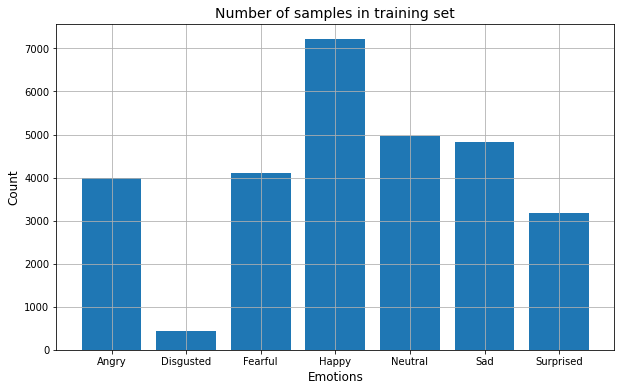

In [106]:
count_df = df.groupby('emotion', as_index=False).count()
for i in count_df.index:
  count_df['emotion'].loc[i] = label_dict[count_df['emotion'].loc[i]]

plt.figure(figsize=(10,6))
plt.bar(count_df['emotion'], count_df['pixels'])
plt.grid()
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of samples in training set', fontsize=14)
plt.show()

In [12]:
pixel_data = df['pixels']
label_data = df['emotion']

In [13]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    x = pixel_data[i]
    x = x.replace('[', '')
    x = x.replace(']', '')
    img = np.fromstring(x, dtype='float32', sep=', ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)
  
 

  return X

In [14]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

In [15]:
X = preprocess_pixels(X_over_series)
Y = np.array(Y_over).astype('float32')
Y = Y.reshape(Y.shape[0],1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [16]:
def emotion_recognition(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  # X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  # X = BatchNormalization(axis=3)(X)
  # X = Activation('relu')(X)

  X = Conv2D(16, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(32, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  # X = BatchNormalization(axis=3)(X)
  # X = Activation('relu')(X)

  X = Conv2D(32, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.7)(X)
  X = Dense(7, activation = 'softmax')(X)

  model = Model(inputs=X_input, outputs=X)

  return model

In [17]:
model = emotion_recognition((48,48,1))
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
y_train = to_categorical(Y_train, num_classes=7)

y_test = to_categorical(Y_test, num_classes=7)

In [ ]:
# model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

In [71]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#   json_file.write(model_json)
#   model.save_weights("/content/drive/MyDrive/emotion_model_60pc_2.h5")
#   print("Saved model to disk")

Saved model to disk


In [ ]:
# from google.colab import files
# files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# from keras.models import load_weights()
# from keras.models.Model import load_weights
model = emotion_recognition((48,48,1))
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/content/drive/MyDrive/emotion_model_60pc_2.h5')

In [28]:
preds = model.predict(X_train)
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(preds)

1263/1263 [==============================] - 53s 42ms/step


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [30]:
# def predict_emo(label_dict, img_path):
#   # img_path = 'im43.png'
#   # img = image.load_img(img_path, grayscale=True, target_size=(48,48))

#   img = tf.keras.utils.load_img(img_path, grayscale=True, target_size=(48,48))


#   x = tf.keras.utils.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   prediction = np.argmax(model.predict(x))
#   return label_dict[prediction]
#   # print('The predicted emotion is : ' + label_dict[prediction])
#   # my_image = tf.keras.utils.load_img(img_path)
#   # plt.imshow(my_image)

In [132]:
np.random.choice(range(5),2, replace=False)

array([1, 4])

In [171]:
def predict_emo(label_dict, emotn):
  
  plt.figure(figsize=(30,4))
  fig_id = 1
  base_path = '/content/drive/MyDrive/test_short/'+emotn+'/'

  random_list = np.random.choice(range(51),5, replace=False)

  for ima in random_list:

    img_path = base_path+'im'+str(ima)+'.png'
    img = tf.keras.utils.load_img(img_path, grayscale=True, target_size=(48,48))


    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predictions = model.predict(x)
    sorted_indexes = np.flip(np.argsort(predictions))

    predictions = predictions[0]
    sorted_indexes = sorted_indexes[0]
    sorted_indexes = sorted_indexes[:3]
    prediction_dict = {}
    for i in sorted_indexes:
      prediction_dict[i] = round((predictions[i]*100),2)

    

    my_image = tf.keras.utils.load_img(img_path)
    plt.subplot(1,5,fig_id)
    plt.imshow(my_image)

    title_text = ''

    for k in prediction_dict.keys():
      title_text = title_text+label_dict[k]+': '+str(prediction_dict[k])+'%    '

    plt.title(title_text)
    plt.axis('off')
    fig_id+=1

  plt.tight_layout(pad=4)
  plt.suptitle('True label: '+emotn.upper(), fontsize=15)

1/1 [==============================] - 0s 22ms/step


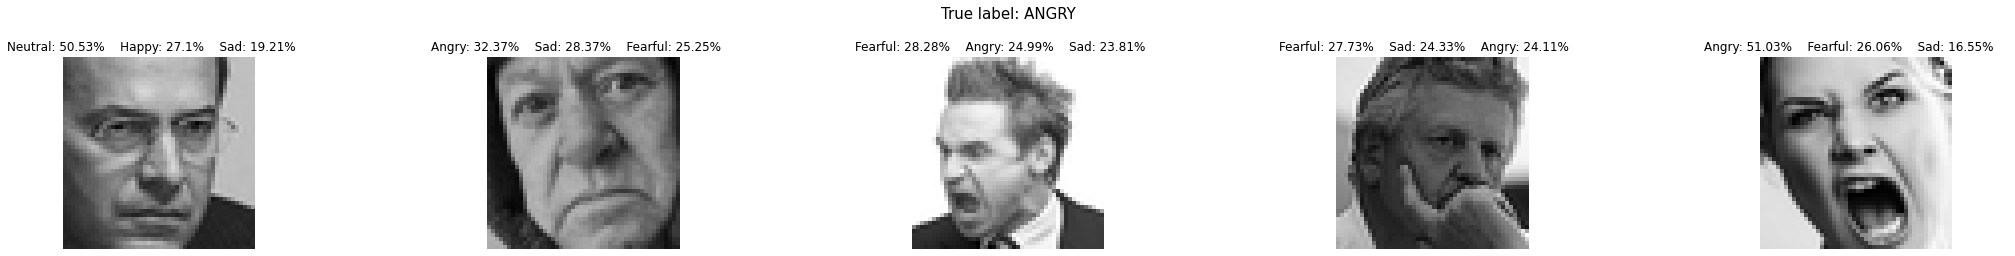

In [178]:
predict_emo(label_dict, 'angry')

1/1 [==============================] - 0s 18ms/step


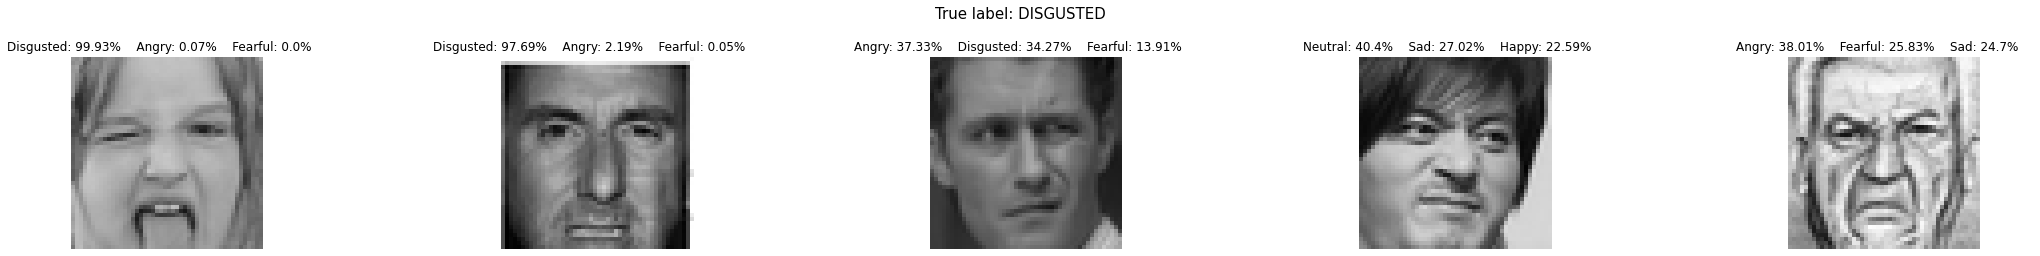

In [180]:
predict_emo(label_dict, 'disgusted')

1/1 [==============================] - 0s 25ms/step


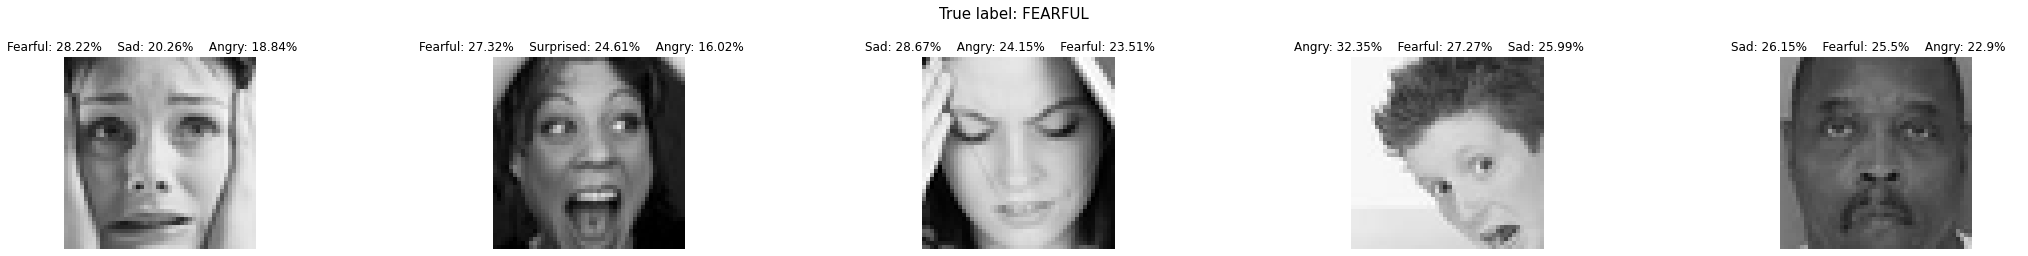

In [181]:
predict_emo(label_dict, 'fearful')

1/1 [==============================] - 0s 22ms/step


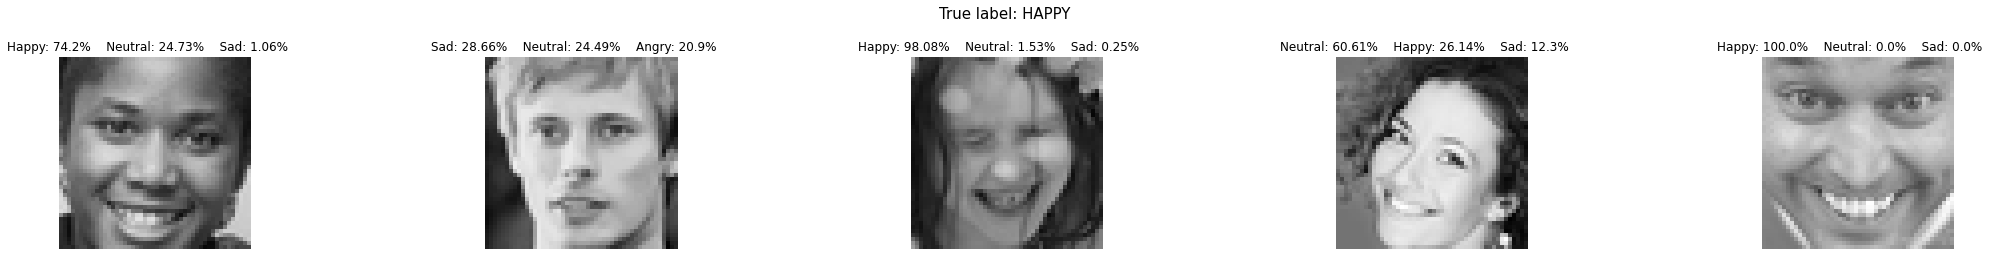

In [182]:
predict_emo(label_dict, 'happy')

1/1 [==============================] - 0s 24ms/step


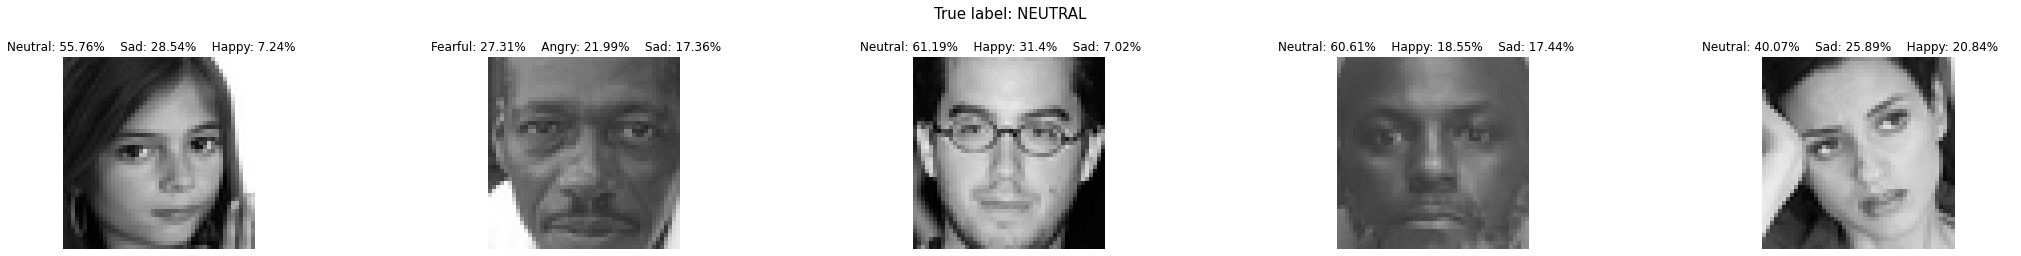

In [183]:
predict_emo(label_dict, 'neutral')

1/1 [==============================] - 0s 34ms/step


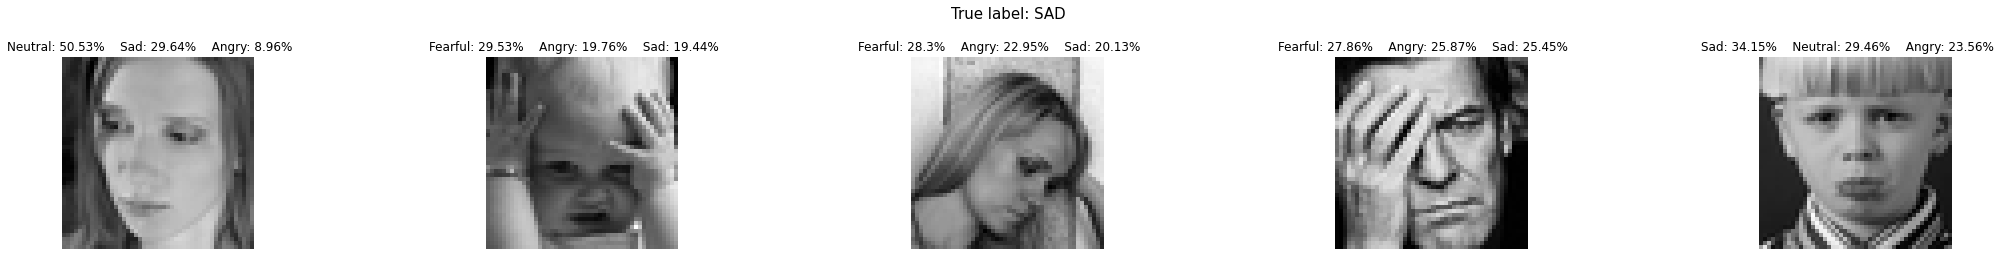

In [184]:
predict_emo(label_dict, 'sad')

1/1 [==============================] - 0s 127ms/step


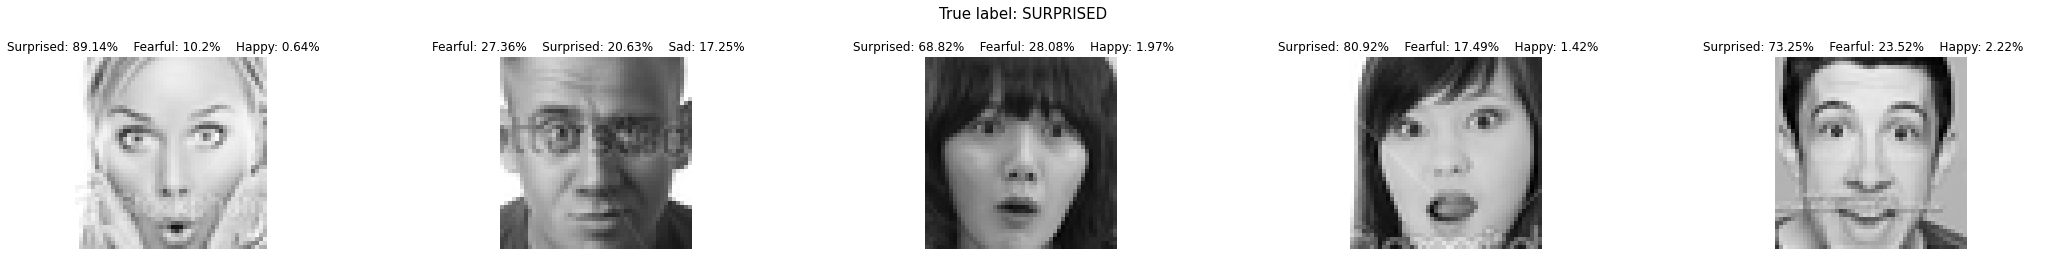

In [185]:
predict_emo(label_dict, 'surprised')